# Building the CCS Tree from Scratch
I am testing the similarity of the graphs generated by our algorithm to the original CCS tree on the testing and training dataset.

In [1]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt

from Scripts.util import ExtractIntLabelFromPred
from Scripts.graphgeneration import BuildRelationList, BuildGraphDictFromRelationList, gbm_classifier, PlotGraphs

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading models

In [2]:
model = fasttext.load_model('Models/Trained_FastText_model.bin')

In [3]:
ft_model = fasttext.load_model('Models/cc.en.300.bin')

In [4]:
gbm_model1 = pickle.load(open("Models/naive_gridsearch_classifier.pkl", "rb"))
gbm_model1

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

In [5]:
gbm_model2 = pickle.load(open("Models/naive_gridsearch_01_classifier.pkl", "rb"))
gbm_model2

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

## Loading Data

In [6]:
labeled_concept_pair_df = pd.read_csv("Data/labeled_concept_pair_dataset.csv")
labeled_concept_pair_df.tail()

,kw1,kw2,label
25934,software testing debugging,combinational synthesis,0
25935,combinational synthesis,power management,0
25936,software fault tolerance,pcb design layout,0
25937,pcb design layout,formal method,0
25938,documentation,pcb design layout,0


## Building the Original Graph from Data

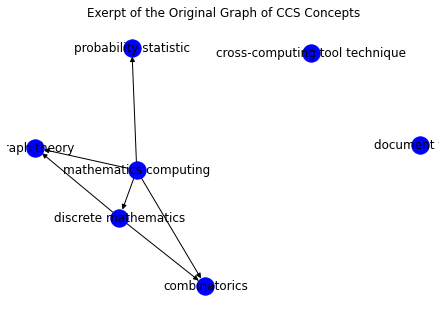

In [7]:
relationList = labeled_concept_pair_df[["kw1", "kw2", "label"]].to_numpy()

ogG   = nx.DiGraph(BuildGraphDictFromRelationList(relationList))
nodes = ogG.nodes()
og_subgraph = ogG.subgraph(list(nodes)[1:8])

og_pos = nx.spring_layout(og_subgraph)

nx.draw(og_subgraph, pos=og_pos, with_labels = True, node_color = 'b')
plt.title("Exerpt of the Original Graph of CCS Concepts")
plt.show()

## Building Graphs from Classifiers

### Using the GBM -1, 0, 1 Classifier

In [8]:
kw_pairs = list(zip(labeled_concept_pair_df["kw1"].to_numpy(), labeled_concept_pair_df["kw2"].to_numpy()))
relationList = BuildRelationList(kw_pairs, kw_pairs, lambda x: gbm_classifier(ft_model.get_sentence_vector, gbm_model1.predict, x))

gbm1G = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

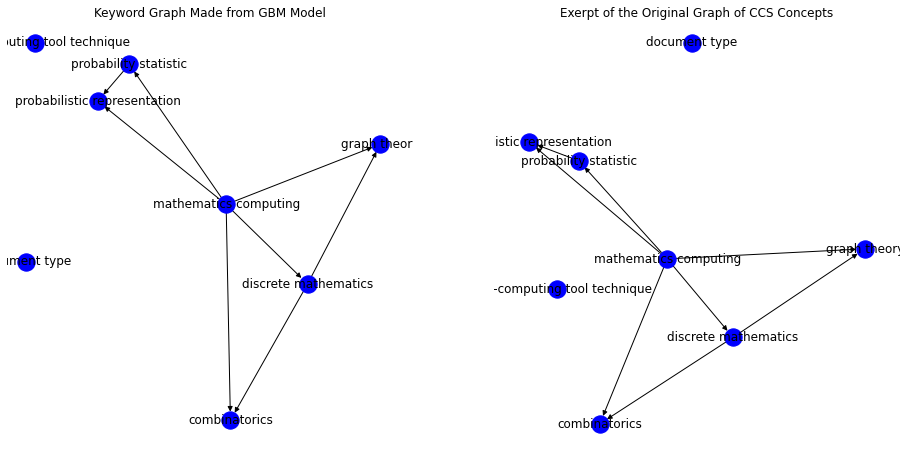

The edit disance between both subgraphs is: 0.0


In [78]:
## Show subgraphs
PlotGraphs(nodes, gbm1G, ogG, starting_node=1, num_nodes=9, title1="Keyword Graph Made from GBM Model", title2="Exerpt of the Original Graph of CCS Concepts")

### Using the GBM 0, 1 Classifier

In [9]:
kw_pairs = list(zip(labeled_concept_pair_df["kw1"].to_numpy(), labeled_concept_pair_df["kw2"].to_numpy()))
relationList = BuildRelationList(kw_pairs, kw_pairs, lambda x: gbm_classifier(ft_model.get_sentence_vector, gbm_model2.predict, x))

gbm2G = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

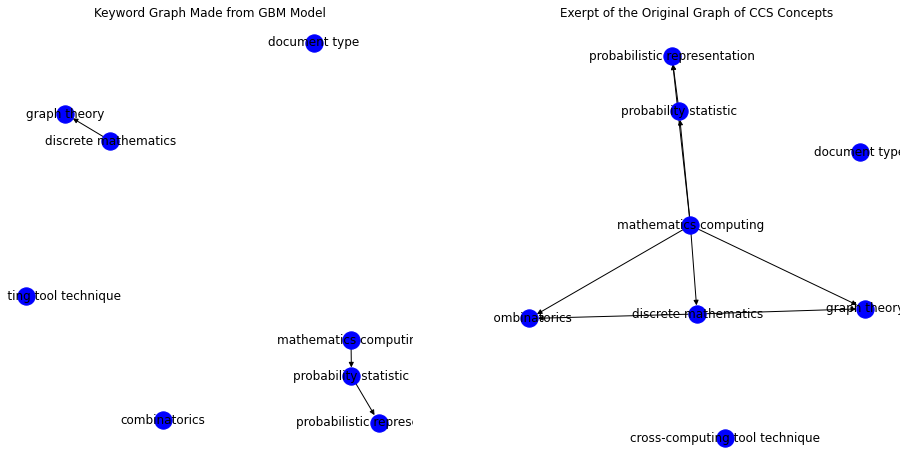

The edit disance between both subgraphs is: 5.0


In [113]:
## Show subgraphs
PlotGraphs(nodes, gbm2G, ogG, starting_node=1, num_nodes=9, title1="Keyword Graph Made from 01 GBM Model", title2="Exerpt of the Original Graph of CCS Concepts")

### Using the FastText -1, 0, 1 classifier

In [10]:
relationList = BuildRelationList(kw_pairs, [", ".join(pair) for pair in kw_pairs], lambda x: ExtractIntLabelFromPred(model.predict(x)))

ftG = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

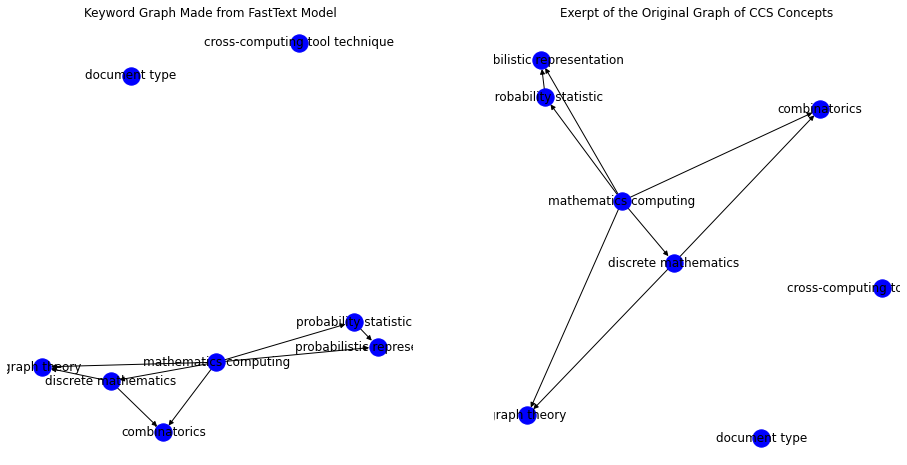

The edit disance between both subgraphs is: 0.0


In [35]:
PlotGraphs(nodes, ftG, ogG, starting_node=1, num_nodes=9, title1="Keyword Graph Made from FastText Model", title2="Exerpt of the Original Graph of CCS Concepts")

### Distances Between Graphs

In [11]:
## Get all three adjacency matrices
og_adjacency_matrix   = nx.to_numpy_matrix(ogG)
gbm1_adjacency_matrix = nx.to_numpy_matrix(gbm1G)
gbm2_adjacency_matrix = nx.to_numpy_matrix(gbm2G)
ft_adjacency_matrix   = nx.to_numpy_matrix(ftG)

In [12]:
adj_shape = og_adjacency_matrix.shape
nb_possible_rel = adj_shape[0] * adj_shape[1]
adj_shape

(1925, 1925)

#### $\mathrm{L}_2$ norm
$||A||_2 = \underset{||x||_2 \leq 1}{\mathrm{sup}} ||Ax||_2$; gives the largest singular value.

##### Defining the norm

In [13]:
## Defining the norm
def L2norm(mat1, mat2):
    return np.linalg.norm(mat1 - mat2, ord=2)

##### Computing

In [14]:
L2norm(gbm1_adjacency_matrix, og_adjacency_matrix)

24.988693776118286

In [15]:
L2norm(gbm2_adjacency_matrix, og_adjacency_matrix)

21.11471920340974

In [16]:
L2norm(ft_adjacency_matrix, og_adjacency_matrix)

25.117190665019148

#### $\mathrm{L}_1$ norm
$||A||_1 = \underset{i}{max} \underset{j}{\sum} |A|_{i,j}$

##### Defining the norm

In [17]:
def L1norm(mat1, mat2):
    return np.linalg.norm(mat1 - mat2, ord=1)

##### Computing

In [18]:
L1norm(gbm1_adjacency_matrix, og_adjacency_matrix)

17.0

In [19]:
L1norm(gbm2_adjacency_matrix, og_adjacency_matrix)

16.0

In [20]:
L1norm(ft_adjacency_matrix, og_adjacency_matrix)

19.0

#### Frobenius norm
$||A||_{F}:= (\mathrm{tr}A^{*}A)^{0.5} = \sqrt{\underset{i,j}{\sum} |A_{i,j}|^2}$

##### Defining the norm

In [21]:
def frobnorm(mat1, mat2):
    return np.linalg.norm(mat1 - mat2, ord='fro')

##### Computing

In [22]:
frobnorm(gbm1_adjacency_matrix, og_adjacency_matrix)

105.40398474441088

In [23]:
frobnorm(gbm2_adjacency_matrix, og_adjacency_matrix)

92.84395510748128

In [24]:
frobnorm(ft_adjacency_matrix, og_adjacency_matrix)

106.96261028976434

#### Missclassification Rate

##### Over all relations possible

In [25]:
print("Missclassification percentage for gbm1 classifier: {:.4f}%".format(np.abs(gbm1_adjacency_matrix - og_adjacency_matrix).sum()/nb_possible_rel*100))

Missclassification percentage for gbm1 classifier: 0.2998%


In [26]:
print("Missclassification percentage for gbm2 classifier: {:.4f}%".format(np.abs(gbm2_adjacency_matrix - og_adjacency_matrix).sum()/nb_possible_rel*100))

Missclassification percentage for gbm2 classifier: 0.2326%


In [27]:
print("Missclassification percentage for FastText classifier: {:.4f}%".format(np.abs(ft_adjacency_matrix - og_adjacency_matrix).sum()/nb_possible_rel*100))

Missclassification percentage for FastText classifier: 0.3087%


##### Over tested relations only

In [28]:
print("Missclassification percentage for gbm1 classifier: {:.4f}%".format(np.abs(gbm1_adjacency_matrix - og_adjacency_matrix).sum()/labeled_concept_pair_df.shape[0]*100))

Missclassification percentage for gbm1 classifier: 42.8313%


In [29]:
print("Missclassification percentage for gbm2 classifier: {:.4f}%".format(np.abs(gbm2_adjacency_matrix - og_adjacency_matrix).sum()/labeled_concept_pair_df.shape[0]*100))

Missclassification percentage for gbm2 classifier: 33.2318%


In [30]:
print("Missclassification percentage for FastText classifier: {:.4f}%".format(np.abs(ft_adjacency_matrix - og_adjacency_matrix).sum()/labeled_concept_pair_df.shape[0]*100))

Missclassification percentage for FastText classifier: 44.1073%


## Number of connected components for each graph

### Definitions:
For directed graphs, the notion of connected components is more complex:
1. Strongly connected components:<br>
There is a directed path between node A to node B and another from node B to node A.
2. Weakly connected components:<br>
There is a directed path from node A to node B but not necessarily from node B to node A.

In [31]:
## Get the weakly connected components of the directed graphs:
og_comp   = list(nx.weakly_connected_components(ogG))
gbm1_comp = list(nx.weakly_connected_components(gbm1G))
gbm2_comp = list(nx.weakly_connected_components(gbm2G))
ft_comp   = list(nx.weakly_connected_components(ftG))

In [32]:
## Python program to print the data
print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('','Original Graph','GBM1 Graph','GBM2 Graph', 'FastText Graph'))
print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format("Number of weakly cc", len(og_comp), len(gbm1_comp), len(gbm2_comp), len(ft_comp)))

                     Original Graph       GBM1 Graph           GBM2 Graph           FastText Graph      
Number of weakly cc  1                    3                    280                  7                   


In [33]:
print("Total number of nodes:", len(nodes))

Total number of nodes: 1925


### Remarques et conclusions
- Le classifieur 01 gbm2 a de meilleurs performance selon les métriques. C'est logique pusiqu'il doit prendre moins de risque. En effet, c'est une classification binaire à la place d'une classification ternaire. Ceci dit, dans son ensemble d'entrainement, il y a beaucoup plus de 0. Il lie donc beaucoup moins les sommets entre eux que les autres algorithmes. On a donc des matrices d'adjacences beaucoup plus sparses et on obtient un graph avec beaucoup plus de composantes connexes.
- Je pense qu'on peut trouver une stratégie pour nettoyer le graph de GBM1 pour le rendre plus précis en gardant sa connexité.